In [4]:
from __future__ import print_function, division

import numpy as np
import random 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd
import numpy as np

from PIL import Image
from sklearn.model_selection import train_test_split

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
torch.cuda.is_available()

True

In [6]:
seed = 100
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
jdf = pd.read_excel("./csvs/Joint_images_Feature_extracted_GLCM_AllScores.xlsx", index_col = 0).replace({"F":0,"C":0 })

In [8]:
jdf = pd.read_excel("./csvs/Joint_images_Feature_extracted_GLCM_AllScores.xlsx", index_col = 0).replace({"F":0,"C":0 }).dropna()
jdf["Erosion Score"] = jdf["Erosion Score"].astype(np.int32)
jdf["JSN_Score"] = jdf["JSN_Score"].astype(np.int32)
jdf.tail()

,Patient_ID,Joint_Type,Timepoint,dissimilarity,contrast,homogeneity,ASM,energy,correlation,mean,skewness,kurtosis,variance,Filename,Erosion Score,JSN_Score,Total Score E,Total Score J,Total Score J+E
20784,10-991,Wrist_1,E,9.662078,209.950273,0.129852,0.000461,0.021473,0.959190,185.763306,-1.732832,2.545928,2696.685839,10-991_E_HandLeft_left_Wrist_1.tif,0,0,0.0,0.0,0.0
14295,10-991,Wrist_1,G,15.261285,512.845858,0.093543,0.000187,0.013678,0.831193,120.273376,-0.001153,-0.521732,1545.048803,10-991_G_Hands_left_Wrist_1.tif,0,0,0.0,0.0,0.0
42439,10-991,Wrist_1,G,14.920697,481.188430,0.097568,0.000188,0.013704,0.841581,118.306702,-0.222813,-0.246106,1541.802467,10-991_G_Hands_right_Wrist_1.tif,0,0,0.0,0.0,0.0
2828,10-991,Wrist_1,H,13.858135,427.640253,0.095111,0.000221,0.014875,0.823849,163.512390,-1.178939,2.638571,1281.800982,10-991_H_HandLeft_left_Wrist_1.tif,0,0,0.0,0.0,0.0
44287,10-991,Wrist_1,H,12.905878,384.210938,0.143963,0.001250,0.035361,0.949524,138.072693,-1.044463,-0.102034,3935.557250,10-991_H_HandRight_right_Wrist_1.tif,0,0,0.0,0.0,0.0


In [6]:
from loaders import ObtainJointImagesData, JointImageDatasetMultiTask
data_both = JointImageDatasetMultiTask(ObtainJointImagesData(score_type="Both", filter_joint="ulna", filter_score=4, binarize=False).get_data().values(), data_type='train')
# test_data = JointImageDataset(ObtainJointImagesData(score_type="E").get_test_data(), data_type='val')

In [7]:
print("Erosion (MCP, PIP) ", len(data_both))

Erosion (MCP, PIP)  2770


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on ", device)
class_names = data_both.classes
print(class_names)

Running on  cuda
[0 1 2 3 5]


In [9]:
IMAGE_SIZE = (224, 224)

In [10]:
from collections import Counter
def count_score_counts(df):
    e = [d[0].item() for d in df]
    j = [d[1].item() for d in df]
    print(Counter(e), Counter(j))

In [11]:
X, y = ObtainJointImagesData(score_type="Both",filter_joint="ulna", filter_score=4, binarize=False).get_data().values()

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, stratify = y[:,0], test_size=0.3, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=69)


patient_split_data = ObtainJointImagesData(score_type="Both",filter_joint=None, binarize=False).get_patient_split_data()
(X_train, y_train), (X_val, y_val), (X_test, y_test) = patient_split_data['train'].values(), patient_split_data['val'].values(), patient_split_data['test'].values()
# # Weighted Sampling
# class_count = [i for i in Counter(y_train.numpy()).values()]
# #class_count.extend([class_count[-1], class_count[-1]])

# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# class_weights_all = class_weights[y_train.numpy()]

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )

count_score_counts(y_test)

train_dl = torch.utils.data.DataLoader(JointImageDatasetMultiTask((X_train, y_train), data_type="train", image_size=IMAGE_SIZE), batch_size=32, num_workers=0)

val_dl = torch.utils.data.DataLoader(JointImageDatasetMultiTask((X_val, y_val), data_type="val", image_size=IMAGE_SIZE), batch_size=32,
                                             shuffle=True, num_workers=0)

test_dl = torch.utils.data.DataLoader(JointImageDatasetMultiTask((X_test, y_test), data_type="val", image_size=IMAGE_SIZE), batch_size=32,
                                             shuffle=True, num_workers=0)

Counter({0: 8566, 1: 459, 2: 161, 3: 35, 5: 18, 4: 9}) Counter({0: 8537, 1: 436, 2: 191, 3: 57, 5: 18, 4: 9})


In [12]:
# Data loaders
train_loader = train_dl
val_loader = val_dl
test_loader = test_dl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


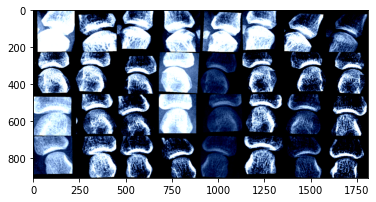

In [13]:
inputs, e, j = next(iter(train_loader))
for i in range(2):
    # Get a batch of training data
    inputs, e, j = next(iter(train_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    plt.imshow(out.permute(1, 2, 0))

In [63]:
from sklearn.metrics import matthews_corrcoef, r2_score, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error
import seaborn as sns
import math
from performance_metrics import evaluate_test_set_multi_task, roc_auc_score_multiclass, multi_acc, accuracy, multi_mcc, root_mean_squared_error, save_confusion_matrix, draw_roc_curve, evaluate_test_set, calculate_roc_plot
from sklearn.metrics import roc_curve, auc

def calculate_roc_plot_test(y_score, y_test, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_pred = [[]] * len(y_test)
    for i, t in enumerate(y_test):
        arr = [0] * (n_classes+1)
        arr[t] = 1
        y_test_pred[i] = arr
    y_test_pred = np.array(y_test_pred)
        
    for i in range(n_classes):
        print(y_test_pred, y_score)
        fpr[i], tpr[i], _ = roc_curve(y_test_pred[i, :], y_score[i, :])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

def save_best_dict(test_metrics, best_dict):
    acc, f1, roc, e = test_metrics

    if(best_dict["accuracy"] > acc):
        best_dict["accuracy"] = acc
    elif(best_dict["f1_score"] > f1):
        best_dict["f1_score"] = f1
        best_dict["roc_auc"] = roc
    
    return best_dict

def draw_roc_multiclass(X,y,model, classes=class_names):
    visualizer = ROCAUC(model, classes=classes)

    visualizer.fit(X, y)        # Fit the training data to the visualizer
    visualizer.score(X, X)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    plt.savefig()

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [64]:
from models import CNN_MC, MTL_ViTModule
## Is it Regression analysis or multi-class classification?
IsRegression = False
# Epochs and LR Scheduler gamma
EPOCHS = 200
gamma = 0.6

# Learning rate to begin with. Num of classes for multi-class classification
LEARNING_RATE = 0.00001
NUM_CLASSES = 1

model = MTL_ViTModule(input_size = IMAGE_SIZE, output_size = NUM_CLASSES)
model.to(device)

## Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Fine-tune first four params
for param in reversed(list(model.parameters())[-10:]):
    param.requires_grad = True

# for param in reversed(list(model.parameters())):
#     if(param.requires_grad == True):
#         print(param)
# weight=class_weights.to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.MSELoss()
if(IsRegression == True):
    criterion = nn.MSELoss()

# model = Ditill_ViT(input_size=(224, 224), output_size = NUM_CLASSES)
# distill_criterion = model.get_distiller

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [65]:
import torch
foo = torch.tensor([1,2,3])
foo = foo.to('cuda:2')

In [71]:
import gc
gc.collect()
torch.cuda.set_device(2)
torch.cuda.empty_cache() # Clear CUDA memory

In [72]:
import json 

# Define model name for filenames
MODEL_NAME_BASE = "ViT_MultiTask_Patient_Split"
if(IsRegression == True):
    MODEL_NAME_BASE = "ViT_MSE_"

MODEL_NAME = MODEL_NAME_BASE + "_EJ"

train_metrics = []
val_metrics = []
test_metrics = []

def save_metrics(acc_stats, f1_stats, rmse_stats, roc_stats, prefix="final"):
    cols = []
    stat_dict = {}
    for t in ["train", "val", "test"]:
        for m in ["accuracy", "f1", "rmse", "auc_roc"]:
            stats = None
            if(m == "accuracy"):
                stats = acc_stats
            elif(m == "f1"):
                stats = f1_stats
            elif(m == "rmse"):
                stats = rmse_stats
            elif(m == "auc_roc"):
                stats = roc_stats

            key = f"{t}_{m}"
            stat_dict[key] = stats[t]
            

    accuracy = [acc_stats["train"], acc_stats["val"], acc_stats["test"]]
    f1 = [f1_stats["train"], f1_stats["val"], f1_stats["test"]]
    rmse = [rmse_stats["train"], rmse_stats["val"], rmse_stats["test"]]
    auc_roc = [roc_stats["train"], roc_stats["val"], roc_stats["test"]]
    data = [*accuracy, *f1, *rmse, *auc_roc]
    df = pd.DataFrame(stat_dict)
    df.to_csv(f"./logs/{MODEL_NAME}_{prefix}_results.csv")


def save_metrics_multi_score(acc_stats, f1_stats, rmse_stats, roc_stats, prefix="final"):
    cols = []
    stat_dict = {}
    for s in ["E", "J"]:
        for t in ["train", "val", "test"]:
            for m in ["accuracy", "f1", "rmse", "auc_roc"]:
                stats = None
                if(m == "accuracy"):
                    stats = acc_stats
                elif(m == "f1"):
                    stats = f1_stats
                elif(m == "rmse"):
                    stats = rmse_stats
                elif(m == "auc_roc"):
                    stats = roc_stats

                key = f"{t}_{m}_{s}"
                stat_dict[key] = stats[s][t]
            

    df = pd.DataFrame(stat_dict)
    df.to_csv(f"./logs/{MODEL_NAME}_{prefix}_results.csv")

In [73]:
def get_performance_metrics(y_batch, y_hat, weights=None, isRegression=True):
    '''
    Calculate Performance Metrics
        y_batch = The truth values
        y_hat = The predicitons from the model
    '''
    y_batch = y_batch.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
    

    # Weights of samples
    # class_keys = [i for i in Counter(np.squeeze(y_batch)).keys()]
    # class_count = [i for i in Counter(np.squeeze(y_batch)).values()]
    # class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    # print(class_keys, class_weights, np.squeeze(y_batch))
    
    # Define class weights for samples
    acc = accuracy_score(y_batch, y_hat)
    
    # Sample weights for balanced accuracy
    if(weights != None):
        class_weights_all = weights[np.squeeze(y_batch)]
        acc = balanced_accuracy_score(y_batch, y_hat, sample_weight=class_weights_all)

    r2 = r2_score(y_batch, y_hat)
    f1 = f1_score(y_batch, y_hat, average="macro", labels=np.unique(y_hat))
    rmse = root_mean_squared_error(y_batch, y_hat)
    roc_auc = 0
    try:
        roc_auc = roc_auc_score(y_batch, y_hat,average='weighted')
    except:
        roc_auc = 0
        

    return {'accuracy':acc, 'r2':r2, 'f1':f1, 'rmse':rmse, 'roc_auc':roc_auc}



In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
import tqdm
import pprint 
from time import time
pp = pprint.PrettyPrinter() # Pretty print

# Prepare the diagram for CNN architecture and vision transformer
best_test_f1 = 0
best_test_dict = {
    "epoch":-1,
    "f1_score":-1,
    "accuracy":-1,
    "roc_auc":-1
}

if __name__ == '__main__':    

    accuracy_stats = {
        "E":{
            'train': [],
            "val": [],
            "test": []
        },
        "J":{
            'train': [],
            "val": [],
            "test": []
        }
       
    }
    loss_stats = {
     "E":{
            'train': [],
            "val": [],
            "test": []
        },
        "J":{
            'train': [],
            "val": [],
            "test": []
        }
    }
    r2_stats = {
       "E":{
            'train': [],
            "val": [],
            "test": []
        },
        "J":{
            'train': [],
            "val": [],
            "test": []
        }
    }
    f1_stats = {
     "E":{
            'train': [],
            "val": [],
            "test": []
        },
        "J":{
            'train': [],
            "val": [],
            "test": []
        }
    }
    roc_auc_stats = {
     "E":{
            'train': [],
            "val": [],
            "test": []
        },
        "J":{
            'train': [],
            "val": [],
            "test": []
        }
    }
    rmse_stats = {
     "E":{
            'train': [],
            "val": [],
            "test": []
        },
        "J":{
            'train': [],
            "val": [],
            "test": []
        }
    }
    print("Begin training.")
    for e in tqdm.tqdm(range(1, EPOCHS+1)):
        # TRAINING
        train_epoch_loss = {
            "E":0,
            "J":0
        }
        train_epoch_acc = {
            "E":0,
            "J":0
        }
        train_epoch_r2 = {
            "E":0,
            "J":0
        }
        train_epoch_f1 = {
            "E":0,
            "J":0
        }
        train_epoch_rmse = {
            "E":0,
            "J":0
        }
        train_epoch_roc = {
            "E":0,
            "J":0
        }

        batch_y_true = []
        batch_y_hat = []

        val_y_true = []
        val_y_hat = []

        model.train()

        for X_train_batch, y_train_batch_e, y_train_batch_j in train_loader:
            
            X_train_batch, y_train_batch_e, y_train_batch_j = X_train_batch.to(device), y_train_batch_e.to(device), y_train_batch_j.to(device)

            preds = model(X_train_batch)
            (y_train_pred_e, y_train_pred_j) = preds
            y_train_pred_e, y_train_pred_j = y_train_pred_e.float(), y_train_pred_j.float()
            y_train_hat_e,y_train_hat_j = torch.round(y_train_pred_e).detach(), torch.round(y_train_pred_j).detach()
            y_train_hat_e, y_train_hat_j= y_train_hat_e.squeeze(0).float(), y_train_hat_j.squeeze(0).float()
       

    
            train_loss_e = criterion(y_train_pred_e.to(torch.float32), y_train_batch_e.to(torch.float32))
            train_loss_j = criterion(y_train_pred_j.to(torch.float32), y_train_batch_j.to(torch.float32))
            #distill_loss = distill_criterion(X_train_batch, y_train_batch)
            train_metrics_e = get_performance_metrics(y_train_batch_e, y_train_hat_e, weights=None)
            train_metrics_j = get_performance_metrics(y_train_batch_j, y_train_hat_j, weights=None)

            train_acc, train_r2, train_f1, train_rmse, train_roc = train_metrics_e['accuracy'], train_metrics_e['r2'], train_metrics_e['f1'], train_metrics_e['rmse'], train_metrics_e['roc_auc'] 
            train_acc_j, train_r2_j, train_f1_j, train_rmse_j, train_roc_j = train_metrics_j['accuracy'], train_metrics_j['r2'], train_metrics_j['f1'], train_metrics_j['rmse'], train_metrics_j['roc_auc'] 
            
            # train_acc = accuracy_score(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy())
            # train_mcc = multi_mcc(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy())
            # train_f1 = f1_score(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy(), average="macro", labels=np.unique(y_train_hat.cpu().numpy()))
            # train_rmse = root_mean_squared_error(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy())
            batch_y_true.extend(y_train_batch_e.cpu().numpy())
            batch_y_hat.extend(y_train_hat_e.cpu().numpy())

            final_loss = train_loss_e + train_loss_j


            optimizer.zero_grad()
            final_loss.backward()
            #distill_loss.backward()
            optimizer.step()
            

            train_epoch_loss["E"] += final_loss.item()

            # For Erosion
            train_epoch_acc["E"] += train_acc
            train_epoch_r2["E"] += train_r2
            train_epoch_f1["E"] += train_f1
            train_epoch_rmse["E"] += train_rmse
            train_epoch_roc["E"] += train_roc

            # For JSN
            train_epoch_acc["J"] += train_acc_j
            train_epoch_r2["J"] += train_r2_j
            train_epoch_f1["J"] += train_f1_j
            train_epoch_rmse["J"] += train_rmse_j
            train_epoch_roc["J"] += train_roc_j
            
            # if(e % 10 == 0):
            #     # Draw ROC Curve for Train
            #     # draw_roc_curve(X_train_batch.cpu().detach().numpy(), y_train_batch.cpu().detach().numpy(), y_train_pred.cpu().detach().numpy(), model.classes, f"{MODEL_NAME}_{e}_roc")
                    
            torch.cuda.empty_cache() # Clear CUDA memory
            
            
        # VALIDATION    
        with torch.no_grad():
        
            val_epoch_loss = {
                "E":0,
                "J":0
            }
            val_epoch_acc = {
            "E":0,
            "J":0
                }
            val_epoch_r2 = {
            "E":0,
            "J":0
                }
            val_epoch_f1 = {
            "E":0,
            "J":0
                }
            val_epoch_rmse = {
            "E":0,
            "J":0
                }
            val_epoch_roc = {
            "E":0,
            "J":0
                }
        

            model.eval()
            for X_val_batch, y_val_batch_e, y_val_batch_j in val_loader:

                X_val_batch, y_val_batch_e, y_val_batch_j = X_val_batch.to(device), y_val_batch_e.to(device), y_val_batch_j.to(device)

                val_preds = model(X_val_batch)
                (y_val_pred_e, y_val_pred_j) = val_preds
                y_val_pred_e, y_val_pred_j = y_val_pred_e.float(), y_val_pred_j.float()
                y_val_hat_e,y_val_hat_j = torch.round(y_val_pred_e).detach(), torch.round(y_val_pred_j).detach()
                y_val_hat_e, y_val_hat_j= y_val_hat_e.squeeze(0).float(), y_val_hat_j.squeeze(0).float()
        

        
                val_loss_e = criterion(y_val_pred_e.to(torch.float32), y_val_batch_e.to(torch.float32))
                val_loss_j = criterion(y_val_pred_j.to(torch.float32), y_val_batch_j.to(torch.float32))
                #distill_loss = distill_criterion(X_train_batch, y_train_batch)
                val_metrics_e = get_performance_metrics(y_val_batch_e, y_val_hat_e, weights=None)
                val_metrics_j = get_performance_metrics(y_val_batch_j, y_val_hat_j, weights=None)

                val_acc, val_r2, val_f1, val_rmse, val_roc= val_metrics_e['accuracy'], val_metrics_e['r2'], val_metrics_e['f1'], val_metrics_e['rmse'], val_metrics_e['roc_auc']
                val_acc_j, val_r2_j, val_f1_j, val_rmse_j, val_roc_j = val_metrics_j['accuracy'], val_metrics_j['r2'], val_metrics_j['f1'], val_metrics_j['rmse'], val_metrics_j['roc_auc']
            

                val_loss = val_loss_e + val_loss_j

                val_y_true.extend(y_val_batch_e.cpu().numpy())
                val_y_hat.extend(y_val_hat_e.cpu().numpy())
                
                
                val_epoch_loss["E"] += val_loss.item()

                # For Erosion
                val_epoch_acc["E"] += val_acc
                val_epoch_r2["E"] += val_r2
                val_epoch_f1["E"] += val_f1
                val_epoch_rmse["E"] += val_rmse
                val_epoch_roc["E"] += val_roc
                # For JSN
                val_epoch_acc["J"] += val_acc_j
                val_epoch_r2["J"] += val_r2_j
                val_epoch_f1["J"] += val_f1_j
                val_epoch_rmse["J"] += val_rmse_j
                val_epoch_roc["J"] += val_roc_j
                torch.cuda.empty_cache() # Clear CUDA memory


        
        # Evaluate on test and save best result
        test_metrics = evaluate_test_set_multi_task(model, test_loader, e,regression = IsRegression, class_weights = None)
        
        test_acc, test_r2, test_f1, test_rmse, test_roc= test_metrics['accuracy'][0], test_metrics['r2'][0], test_metrics['f1'][0], test_metrics['rmse'][0], test_metrics['roc_auc'][0] 
        test_acc_j, test_r2_j, test_f1_j, test_rmse_j, test_roc_j = test_metrics['accuracy'][1], test_metrics['r2'][1], test_metrics['f1'][1], test_metrics['rmse'][1], test_metrics['roc_auc'][1] 
        
        # Store results 
        loss_stats["E"]['train'].append(train_epoch_loss["E"]/len(train_dl))
        loss_stats["E"]['val'].append(val_epoch_loss["E"]/len(val_dl))
        
        # ACCURACY
        # JSN
        accuracy_stats["E"]['train'].append(train_epoch_acc["E"]/len(train_dl))
        accuracy_stats["E"]['val'].append(val_epoch_acc["E"]/len(val_dl))
        accuracy_stats["E"]['test'].append(test_acc)
        # Erosion
        accuracy_stats["J"]['train'].append(train_epoch_acc["J"]/len(train_dl))
        accuracy_stats["J"]['val'].append(val_epoch_acc["J"]/len(val_dl))
        accuracy_stats["J"]['test'].append(test_acc_j)

        # F1 SCORE
        # Erosion
        f1_stats["E"]['train'].append(train_epoch_f1["E"]/len(train_dl))
        f1_stats["E"]['val'].append(val_epoch_f1["E"]/len(val_dl))
        f1_stats["E"]['test'].append(test_f1)
        # JSN
        f1_stats["J"]['train'].append(train_epoch_f1["J"]/len(train_dl))
        f1_stats["J"]['val'].append(val_epoch_f1["J"]/len(val_dl))
        f1_stats["J"]['test'].append(test_f1_j)

        # R2_STATS
        # EROSION
        r2_stats["E"]['train'].append(train_epoch_r2["E"]/len(train_dl))
        r2_stats["E"]['val'].append(val_epoch_r2["E"]/len(val_dl))
        r2_stats["E"]['test'].append(test_r2)
        # JSN
        r2_stats["J"]['train'].append(train_epoch_r2["J"]/len(train_dl))
        r2_stats["J"]['val'].append(val_epoch_r2["J"]/len(val_dl))
        r2_stats["J"]['test'].append(test_r2_j)        
        
        # RMSE 
        # EROSION
        rmse_stats["E"]['train'].append(train_epoch_rmse["E"]/len(train_dl))
        rmse_stats["E"]['val'].append(val_epoch_rmse["E"]/len(val_dl))
        rmse_stats["E"]['test'].append(test_rmse)
        # JSN
        rmse_stats["J"]['train'].append(train_epoch_rmse["J"]/len(train_dl))
        rmse_stats["J"]['val'].append(val_epoch_rmse["J"]/len(val_dl))
        rmse_stats["J"]['test'].append(test_rmse_j)
        
        # ROC 
        # EROSION
        roc_auc_stats["E"]['train'].append(train_epoch_roc["E"]/len(train_dl))
        roc_auc_stats["E"]['val'].append(val_epoch_roc["E"]/len(val_dl))
        roc_auc_stats["E"]['test'].append(test_roc)
        # JSN
        roc_auc_stats["J"]['train'].append(train_epoch_roc["J"]/len(train_dl))
        roc_auc_stats["J"]['val'].append(val_epoch_roc["J"]/len(val_dl))
        roc_auc_stats["J"]['test'].append(test_roc_j)

        # roc_auc_stats['train'].append(json.dumps(roc_auc_score_multiclass(batch_y_true, batch_y_hat)))
        # roc_auc_stats['val'].append(json.dumps(roc_auc_score_multiclass(val_y_true, val_y_hat)))
        # roc_auc_stats['test'].append(json.dumps(test_eval[3]))
        
        if(test_f1 > best_test_f1):
            # Store best test results
            best_test_dict = test_metrics
            best_test_f1 = test_f1
            # Store best model dict
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_epoch_loss["E"]/len(val_dl),
            }, f"./logs/{MODEL_NAME}_best_model.ckpt")

        # Save confusion matrix, test metrics, every 5 minutes 
        if(e % 5 == 0):
            save_metrics_multi_score(accuracy_stats,f1_stats,rmse_stats,roc_stats=roc_auc_stats, prefix=e)
            # save_confusion_matrix(val_y_true, val_y_hat, e)
            test_eval = evaluate_test_set_multi_task(model, test_loader, e, True ,regression = IsRegression, class_weights = None)
            print("Best Test metrics till now: ")
            pp.pprint(best_test_dict)
        
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss["E"]/len(train_loader):.5f} | Val Loss: {val_epoch_loss["E"]/len(val_loader):.5f} | Train Acc: {train_epoch_acc["E"]/len(train_loader):.3f} | Val Acc: {val_epoch_acc["E"]/len(val_loader):.3f} | Val F1: {val_epoch_f1["E"]/len(val_loader):.3f} | Val RMSE: {val_epoch_rmse["E"]/len(val_dl)}')
        print(f'Train AUC: {train_epoch_roc["E"]/len(train_loader):.5f} | Val AUC E: {val_epoch_roc["E"]/len(val_loader):.5f} | Val AUC J: {val_epoch_roc["J"]/len(val_loader):.5f}')
        
save_metrics_multi_score(accuracy_stats,f1_stats,rmse_stats,roc_auc_stats)

Begin training.


  0%|          | 1/200 [04:04<13:31:26, 244.65s/it]

Epoch 001: | Train Loss: 2.47197 | Val Loss: 3.30962 | Train Acc: 0.367 | Val Acc: 0.634 | Val F1: 0.180 | Val RMSE: 0.9646226005103247
Train AUC: 0.11220 | Val AUC E: 0.24705 | Val AUC J: 0.21118


  1%|          | 2/200 [08:11<13:30:59, 245.75s/it]

Epoch 002: | Train Loss: 2.08948 | Val Loss: 3.80205 | Train Acc: 0.397 | Val Acc: 0.536 | Val F1: 0.173 | Val RMSE: 1.101561528376127
Train AUC: 0.10518 | Val AUC E: 0.27747 | Val AUC J: 0.22934


  2%|▏         | 3/200 [12:19<13:30:13, 246.77s/it]

Epoch 003: | Train Loss: 1.78149 | Val Loss: 2.54261 | Train Acc: 0.439 | Val Acc: 0.611 | Val F1: 0.179 | Val RMSE: 1.0292484802118518
Train AUC: 0.11924 | Val AUC E: 0.27732 | Val AUC J: 0.23934


  2%|▏         | 4/200 [16:26<13:27:08, 247.08s/it]

Epoch 004: | Train Loss: 1.58677 | Val Loss: 3.56817 | Train Acc: 0.464 | Val Acc: 0.558 | Val F1: 0.186 | Val RMSE: 1.0722959614687324
Train AUC: 0.11017 | Val AUC E: 0.30783 | Val AUC J: 0.25926


  2%|▎         | 5/200 [21:24<14:22:20, 265.34s/it]

Test Metrics | 
Accuracy (E|J):0.27865484429065746 | 0.4023572664359862 
RMSE: 2.2973440301232464 | 1.4327107134391508 
F1: 0.40530658551183246 | 0.5373025824058242  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.46875, 0.297469723183391),
 'f1': (0.5996254322163497, 0.43989681587286683),
 'r2': (-6.140536161737293, -17.225434052924093),
 'rmse': (1.2116076184191615, 2.069196522630844),
 'roc_auc': (0, 0)}
Epoch 005: | Train Loss: 1.34355 | Val Loss: 4.35981 | Train Acc: 0.514 | Val Acc: 0.550 | Val F1: 0.125 | Val RMSE: 1.7225175724081034
Train AUC: 0.11080 | Val AUC E: 0.30603 | Val AUC J: 0.27609


  3%|▎         | 6/200 [25:33<14:00:21, 259.91s/it]

Epoch 006: | Train Loss: 1.18095 | Val Loss: 2.97628 | Train Acc: 0.555 | Val Acc: 0.575 | Val F1: 0.230 | Val RMSE: 1.216199555601619
Train AUC: 0.11433 | Val AUC E: 0.27526 | Val AUC J: 0.21345


  4%|▎         | 7/200 [29:43<13:45:15, 256.56s/it]

Epoch 007: | Train Loss: 1.00214 | Val Loss: 2.83437 | Train Acc: 0.607 | Val Acc: 0.466 | Val F1: 0.178 | Val RMSE: 1.3290875805763622
Train AUC: 0.11395 | Val AUC E: 0.27668 | Val AUC J: 0.25607


  4%|▍         | 8/200 [33:45<13:25:55, 251.85s/it]

Epoch 008: | Train Loss: 0.85830 | Val Loss: 2.37482 | Train Acc: 0.650 | Val Acc: 0.498 | Val F1: 0.181 | Val RMSE: 1.1788296891531214
Train AUC: 0.10753 | Val AUC E: 0.29977 | Val AUC J: 0.23761


  4%|▍         | 9/200 [37:44<13:09:23, 247.98s/it]

Epoch 009: | Train Loss: 0.71644 | Val Loss: 5.24755 | Train Acc: 0.706 | Val Acc: 0.551 | Val F1: 0.168 | Val RMSE: 1.3556064945229722
Train AUC: 0.11381 | Val AUC E: 0.27994 | Val AUC J: 0.22303


  5%|▌         | 10/200 [42:36<13:47:54, 261.44s/it]

Test Metrics | 
Accuracy (E|J):0.48486159169550175 | 0.5772058823529411 
RMSE: 1.3939594196997025 | 1.2187264268991775 
F1: 0.6121932606156465 | 0.687416215843398  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.48486159169550175, 0.5772058823529411),
 'f1': (0.6121932606156465, 0.687416215843398),
 'r2': (-8.451637803949556, -5.322471010985083),
 'rmse': (1.3939594196997025, 1.2187264268991775),
 'roc_auc': (0, 0)}
Epoch 010: | Train Loss: 0.65164 | Val Loss: 2.10562 | Train Acc: 0.743 | Val Acc: 0.672 | Val F1: 0.222 | Val RMSE: 0.952780086747478
Train AUC: 0.10784 | Val AUC E: 0.29224 | Val AUC J: 0.26869


  6%|▌         | 11/200 [46:34<13:20:53, 254.25s/it]

Epoch 011: | Train Loss: 0.57214 | Val Loss: 2.26538 | Train Acc: 0.791 | Val Acc: 0.791 | Val F1: 0.346 | Val RMSE: 0.6510838732854908
Train AUC: 0.10999 | Val AUC E: 0.28107 | Val AUC J: 0.23455


  6%|▌         | 12/200 [50:33<13:02:17, 249.67s/it]

Epoch 012: | Train Loss: 0.50384 | Val Loss: 1.73262 | Train Acc: 0.832 | Val Acc: 0.864 | Val F1: 0.398 | Val RMSE: 0.7821864817954535
Train AUC: 0.11347 | Val AUC E: 0.27731 | Val AUC J: 0.26341


  6%|▋         | 13/200 [54:31<12:46:47, 246.03s/it]

Epoch 013: | Train Loss: 0.44519 | Val Loss: 1.50780 | Train Acc: 0.862 | Val Acc: 0.816 | Val F1: 0.305 | Val RMSE: 0.8643643710128646
Train AUC: 0.11228 | Val AUC E: 0.23066 | Val AUC J: 0.24064


  7%|▋         | 14/200 [58:28<12:35:05, 243.58s/it]

Epoch 014: | Train Loss: 0.38983 | Val Loss: 2.40490 | Train Acc: 0.892 | Val Acc: 0.860 | Val F1: 0.374 | Val RMSE: 0.782366939831115
Train AUC: 0.11051 | Val AUC E: 0.27591 | Val AUC J: 0.27137


  8%|▊         | 15/200 [1:03:20<13:15:35, 258.03s/it]

Test Metrics | 
Accuracy (E|J):0.8595371972318339 | 0.8694852941176471 
RMSE: 0.6473094365930587 | 0.6810109856611501 
F1: 0.8612870038439273 | 0.8619999550717037  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.8595371972318339, 0.8694852941176471),
 'f1': (0.8612870038439273, 0.8619999550717037),
 'r2': (-1.0381244568895118, -0.9741611943881057),
 'rmse': (0.6473094365930587, 0.6810109856611501),
 'roc_auc': (0, 0)}
Epoch 015: | Train Loss: 0.34624 | Val Loss: 0.76777 | Train Acc: 0.910 | Val Acc: 0.890 | Val F1: 0.491 | Val RMSE: 0.5414736545304556
Train AUC: 0.11094 | Val AUC E: 0.25329 | Val AUC J: 0.23726


  8%|▊         | 16/200 [1:07:18<12:52:41, 251.96s/it]

Epoch 016: | Train Loss: 0.31966 | Val Loss: 0.71683 | Train Acc: 0.923 | Val Acc: 0.871 | Val F1: 0.415 | Val RMSE: 0.550062941876353
Train AUC: 0.11195 | Val AUC E: 0.27052 | Val AUC J: 0.25931


  8%|▊         | 17/200 [1:11:16<12:35:29, 247.70s/it]

Epoch 017: | Train Loss: 0.29324 | Val Loss: 1.50526 | Train Acc: 0.934 | Val Acc: 0.860 | Val F1: 0.364 | Val RMSE: 0.9204505891129187
Train AUC: 0.11328 | Val AUC E: 0.23323 | Val AUC J: 0.21863


  9%|▉         | 18/200 [1:15:15<12:23:22, 245.07s/it]

Epoch 018: | Train Loss: 0.26283 | Val Loss: 0.91343 | Train Acc: 0.948 | Val Acc: 0.896 | Val F1: 0.509 | Val RMSE: 0.5241501912891909
Train AUC: 0.11324 | Val AUC E: 0.27760 | Val AUC J: 0.25734


 10%|▉         | 19/200 [1:19:12<12:12:43, 242.89s/it]

Epoch 019: | Train Loss: 0.24502 | Val Loss: 0.62099 | Train Acc: 0.956 | Val Acc: 0.901 | Val F1: 0.552 | Val RMSE: 0.45860723601242365
Train AUC: 0.11102 | Val AUC E: 0.24825 | Val AUC J: 0.26039


 10%|█         | 20/200 [1:24:03<12:51:50, 257.28s/it]

Test Metrics | 
Accuracy (E|J):0.8884083044982699 | 0.8632136678200693 
RMSE: 0.6215736646306395 | 0.6473094365930587 
F1: 0.8732555984740236 | 0.8598486988207766  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.8884083044982699, 0.8632136678200693),
 'f1': (0.8732555984740236, 0.8598486988207766),
 'r2': (-0.8792822411525743, -0.7836033173825856),
 'rmse': (0.6215736646306395, 0.6473094365930587),
 'roc_auc': (0, 0)}
Epoch 020: | Train Loss: 0.22885 | Val Loss: 0.65708 | Train Acc: 0.960 | Val Acc: 0.903 | Val F1: 0.572 | Val RMSE: 0.5165457847847422
Train AUC: 0.11221 | Val AUC E: 0.26165 | Val AUC J: 0.26314


 10%|█         | 21/200 [1:28:01<12:30:12, 251.47s/it]

Epoch 021: | Train Loss: 0.21741 | Val Loss: 0.80461 | Train Acc: 0.963 | Val Acc: 0.893 | Val F1: 0.497 | Val RMSE: 0.5227013359444778
Train AUC: 0.11226 | Val AUC E: 0.25898 | Val AUC J: 0.27205


 11%|█         | 22/200 [1:32:00<12:14:47, 247.68s/it]

Epoch 022: | Train Loss: 0.20739 | Val Loss: 1.26474 | Train Acc: 0.965 | Val Acc: 0.906 | Val F1: 0.588 | Val RMSE: 0.4637808358864524
Train AUC: 0.11150 | Val AUC E: 0.25623 | Val AUC J: 0.24768


 12%|█▏        | 23/200 [1:35:59<12:02:55, 245.06s/it]

Epoch 023: | Train Loss: 0.20066 | Val Loss: 0.68736 | Train Acc: 0.967 | Val Acc: 0.913 | Val F1: 0.651 | Val RMSE: 0.4238812907433577
Train AUC: 0.11108 | Val AUC E: 0.24680 | Val AUC J: 0.23907


 12%|█▏        | 24/200 [1:39:58<11:53:23, 243.20s/it]

Epoch 024: | Train Loss: 0.19633 | Val Loss: 2.04992 | Train Acc: 0.968 | Val Acc: 0.909 | Val F1: 0.608 | Val RMSE: 0.6735500611135437
Train AUC: 0.11173 | Val AUC E: 0.23706 | Val AUC J: 0.23099


 12%|█▎        | 25/200 [1:44:49<12:30:55, 257.46s/it]

Test Metrics | 
Accuracy (E|J):0.8931660899653979 | 0.8960856401384083 
RMSE: 0.5746595286894443 | 0.711147654566303 
F1: 0.8757899267713537 | 0.8739593461082512  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.891219723183391, 0.8961937716262975),
 'f1': (0.8804661313871353, 0.874845803981918),
 'r2': (-2.5865730765237624, -3.4044645532990874),
 'rmse': (0.858690058241738, 1.0172070432505376),
 'roc_auc': (0, 0)}
Epoch 025: | Train Loss: 0.19227 | Val Loss: 0.76201 | Train Acc: 0.969 | Val Acc: 0.911 | Val F1: 0.624 | Val RMSE: 0.4525755305999361
Train AUC: 0.11142 | Val AUC E: 0.23962 | Val AUC J: 0.24333


 13%|█▎        | 26/200 [1:48:45<12:08:08, 251.09s/it]

Epoch 026: | Train Loss: 0.18988 | Val Loss: 0.99206 | Train Acc: 0.970 | Val Acc: 0.912 | Val F1: 0.615 | Val RMSE: 0.45953340153765077
Train AUC: 0.11179 | Val AUC E: 0.24382 | Val AUC J: 0.23957


 14%|█▎        | 27/200 [1:52:43<11:52:52, 247.24s/it]

Epoch 027: | Train Loss: 0.18869 | Val Loss: 0.69537 | Train Acc: 0.970 | Val Acc: 0.909 | Val F1: 0.600 | Val RMSE: 0.4784370317183819
Train AUC: 0.11175 | Val AUC E: 0.25300 | Val AUC J: 0.24287


 14%|█▍        | 28/200 [1:56:41<11:40:47, 244.46s/it]

Epoch 028: | Train Loss: 0.18721 | Val Loss: 0.73358 | Train Acc: 0.970 | Val Acc: 0.910 | Val F1: 0.625 | Val RMSE: 0.46230593246998136
Train AUC: 0.11157 | Val AUC E: 0.25957 | Val AUC J: 0.24888


 14%|█▍        | 29/200 [2:00:40<11:31:52, 242.76s/it]

Epoch 029: | Train Loss: 0.18603 | Val Loss: 0.53603 | Train Acc: 0.971 | Val Acc: 0.912 | Val F1: 0.635 | Val RMSE: 0.43366211001898
Train AUC: 0.11164 | Val AUC E: 0.23930 | Val AUC J: 0.21855


 15%|█▌        | 30/200 [2:05:30<12:08:16, 257.04s/it]

Test Metrics | 
Accuracy (E|J):0.8987889273356401 | 0.9043036332179931 
RMSE: 0.6687539376829211 | 0.5763505303080688 
F1: 0.8998303132555625 | 0.8830691339531207  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.8987889273356401, 0.9043036332179931),
 'f1': (0.8998303132555625, 0.8830691339531207),
 'r2': (-1.1754020009535537, -0.4139946815482072),
 'rmse': (0.6687539376829211, 0.5763505303080688),
 'roc_auc': (0, 0)}
Epoch 030: | Train Loss: 0.18485 | Val Loss: 0.65019 | Train Acc: 0.971 | Val Acc: 0.912 | Val F1: 0.629 | Val RMSE: 0.5649449662149595
Train AUC: 0.11142 | Val AUC E: 0.26627 | Val AUC J: 0.22728


 16%|█▌        | 31/200 [2:09:28<11:47:37, 251.23s/it]

Epoch 031: | Train Loss: 0.18501 | Val Loss: 0.54402 | Train Acc: 0.971 | Val Acc: 0.916 | Val F1: 0.672 | Val RMSE: 0.38492582772635825
Train AUC: 0.11127 | Val AUC E: 0.24801 | Val AUC J: 0.22078


 16%|█▌        | 32/200 [2:13:26<11:32:21, 247.27s/it]

Epoch 032: | Train Loss: 0.18470 | Val Loss: 0.40175 | Train Acc: 0.970 | Val Acc: 0.917 | Val F1: 0.699 | Val RMSE: 0.3940739079144541
Train AUC: 0.11136 | Val AUC E: 0.24780 | Val AUC J: 0.23234


 16%|█▋        | 33/200 [2:17:24<11:20:36, 244.53s/it]

Epoch 033: | Train Loss: 0.18439 | Val Loss: 0.42661 | Train Acc: 0.971 | Val Acc: 0.926 | Val F1: 0.782 | Val RMSE: 0.3642244366297724
Train AUC: 0.11142 | Val AUC E: 0.27348 | Val AUC J: 0.24354


 17%|█▋        | 34/200 [2:21:22<11:11:06, 242.57s/it]

Epoch 034: | Train Loss: 0.18407 | Val Loss: 0.49819 | Train Acc: 0.971 | Val Acc: 0.920 | Val F1: 0.700 | Val RMSE: 0.4384335523390719
Train AUC: 0.11139 | Val AUC E: 0.25270 | Val AUC J: 0.24186


 18%|█▊        | 35/200 [2:26:12<11:46:32, 256.92s/it]

Test Metrics | 
Accuracy (E|J):0.9144679930795848 | 0.9132785467128027 
RMSE: 0.4931406600989363 | 0.6253026944544549 
F1: 0.8915497298293762 | 0.8820702227333508  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.8987889273356401, 0.9043036332179931),
 'f1': (0.8998303132555625, 0.8830691339531207),
 'r2': (-1.1754020009535537, -0.4139946815482072),
 'rmse': (0.6687539376829211, 0.5763505303080688),
 'roc_auc': (0, 0)}
Epoch 035: | Train Loss: 0.18407 | Val Loss: 0.57167 | Train Acc: 0.971 | Val Acc: 0.924 | Val F1: 0.760 | Val RMSE: 0.3777238351253976
Train AUC: 0.11136 | Val AUC E: 0.26469 | Val AUC J: 0.25128


 18%|█▊        | 36/200 [2:30:12<11:27:44, 251.62s/it]

Epoch 036: | Train Loss: 0.18377 | Val Loss: 0.63708 | Train Acc: 0.971 | Val Acc: 0.919 | Val F1: 0.697 | Val RMSE: 0.41679478530933256
Train AUC: 0.11136 | Val AUC E: 0.24301 | Val AUC J: 0.23809


 18%|█▊        | 37/200 [2:34:10<11:12:37, 247.59s/it]

Epoch 037: | Train Loss: 0.18382 | Val Loss: 0.49531 | Train Acc: 0.971 | Val Acc: 0.928 | Val F1: 0.798 | Val RMSE: 0.3869924628643259
Train AUC: 0.11145 | Val AUC E: 0.24578 | Val AUC J: 0.23466


 19%|█▉        | 38/200 [2:38:09<11:01:27, 244.99s/it]

Epoch 038: | Train Loss: 0.18354 | Val Loss: 0.35779 | Train Acc: 0.971 | Val Acc: 0.927 | Val F1: 0.795 | Val RMSE: 0.3467856293644236
Train AUC: 0.11136 | Val AUC E: 0.24817 | Val AUC J: 0.23143


 20%|█▉        | 39/200 [2:42:06<10:51:23, 242.75s/it]

Epoch 039: | Train Loss: 0.18333 | Val Loss: 0.32349 | Train Acc: 0.971 | Val Acc: 0.932 | Val F1: 0.852 | Val RMSE: 0.3475845109714129
Train AUC: 0.11139 | Val AUC E: 0.26990 | Val AUC J: 0.25596


 20%|██        | 40/200 [2:46:56<11:24:52, 256.83s/it]

Test Metrics | 
Accuracy (E|J):0.9191176470588235 | 0.9094939446366782 
RMSE: 0.476638490840609 | 0.5296159746608833 
F1: 0.893503512740603 | 0.883006476828964  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.9061418685121108, 0.9056012110726643),
 'f1': (0.8998895181660691, 0.8780911152200642),
 'r2': (-0.4811247666066749, -0.8162835330043052),
 'rmse': (0.5518136055343671, 0.6532127166324879),
 'roc_auc': (0, 0)}
Epoch 040: | Train Loss: 0.18327 | Val Loss: 0.32457 | Train Acc: 0.971 | Val Acc: 0.933 | Val F1: 0.868 | Val RMSE: 0.330067035256141
Train AUC: 0.11139 | Val AUC E: 0.24940 | Val AUC J: 0.22463


 20%|██        | 41/200 [2:50:54<11:05:51, 251.27s/it]

Epoch 041: | Train Loss: 0.18321 | Val Loss: 0.30139 | Train Acc: 0.971 | Val Acc: 0.930 | Val F1: 0.826 | Val RMSE: 0.3475851145009901
Train AUC: 0.11139 | Val AUC E: 0.25748 | Val AUC J: 0.23876


 21%|██        | 42/200 [2:54:53<10:51:32, 247.42s/it]

Epoch 042: | Train Loss: 0.18322 | Val Loss: 0.30786 | Train Acc: 0.971 | Val Acc: 0.933 | Val F1: 0.866 | Val RMSE: 0.3386404745111084
Train AUC: 0.11139 | Val AUC E: 0.25451 | Val AUC J: 0.22823


 22%|██▏       | 43/200 [2:58:50<10:39:34, 244.43s/it]

Epoch 043: | Train Loss: 0.18322 | Val Loss: 0.31446 | Train Acc: 0.971 | Val Acc: 0.931 | Val F1: 0.841 | Val RMSE: 0.34935097110453406
Train AUC: 0.11139 | Val AUC E: 0.24934 | Val AUC J: 0.24502


 22%|██▏       | 44/200 [3:02:48<10:30:36, 242.54s/it]

Epoch 044: | Train Loss: 0.18327 | Val Loss: 0.29583 | Train Acc: 0.971 | Val Acc: 0.934 | Val F1: 0.886 | Val RMSE: 0.32871350668592775
Train AUC: 0.11139 | Val AUC E: 0.26792 | Val AUC J: 0.25164


 22%|██▎       | 45/200 [3:07:38<11:03:21, 256.78s/it]

Test Metrics | 
Accuracy (E|J):0.9194420415224913 | 0.9184688581314879 
RMSE: 0.476978667478959 | 0.5068731863927792 
F1: 0.9094600242109134 | 0.8920903422391526  
AUC: 0 | 0
Best Test metrics till now: 
{'accuracy': (0.921280276816609, 0.9183607266435986),
 'f1': (0.9103550215591236, 0.909199670760826),
 'r2': (-0.10505793133544872, -0.10100106714300505),
 'rmse': (0.476638490840609, 0.5085769474752269),
 'roc_auc': (0, 0)}
Epoch 045: | Train Loss: 0.18327 | Val Loss: 0.28993 | Train Acc: 0.971 | Val Acc: 0.933 | Val F1: 0.883 | Val RMSE: 0.3282075275558228
Train AUC: 0.11153 | Val AUC E: 0.23644 | Val AUC J: 0.23882


 23%|██▎       | 46/200 [3:11:36<10:44:17, 251.02s/it]

Epoch 046: | Train Loss: 0.18352 | Val Loss: 0.29015 | Train Acc: 0.971 | Val Acc: 0.929 | Val F1: 0.808 | Val RMSE: 0.3408991987571492
Train AUC: 0.11145 | Val AUC E: 0.26258 | Val AUC J: 0.25302


 23%|██▎       | 46/200 [3:12:55<10:45:54, 251.65s/it]


KeyboardInterrupt: 

In [76]:
torch.save({    'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"./logs/{MODEL_NAME}_best_model.ckpt")

In [47]:
for device in range(4):
    t = torch.cuda.get_device_properties(device).total_memory
    r = torch.cuda.memory_reserved(device)
    a = torch.cuda.memory_allocated(device)
    f = (r-a)  # free inside reserved
    print(f"GPU {device} has {f} KB free")

GPU 0 has 0 KB free
GPU 1 has 0 KB free
GPU 2 has 499025408 KB free
GPU 3 has 402653184 KB free


In [ ]:
import seaborn as sns

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_df = pd.DataFrame.from_dict(f1_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_rmse_df = pd.DataFrame.from_dict(rmse_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})


# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
sns.lineplot(data=train_val_f1_df, x = "epochs", y="value", hue="variable", ax=axes[2]).set_title('Train-Val F1-Score/Epoch')
sns.lineplot(data=train_val_rmse_df, x = "epochs", y="value", hue="variable", ax=axes[3]).set_title('Train-Val RMSE/Epoch')
plt.savefig(f"./logs/{MODEL_NAME}_curves.png")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
sns.heatmap(confusion_matrix_df, annot=True)